# Phase 4 – Whole-brain first-level GLM (movie run-02)

**Goal.**  
In this notebook we run a whole-brain first-level GLM for each movie subject
using the run-02 design matrices from Phase 3. For every subject we:

- load their run-02 BOLD fMRI data and brain mask,
- fit a voxel-wise GLM with our `scene_hrf` regressor,
- compute a contrast testing the movie‐scene effect,
- save a subject-level z-map (`scene_hrf` > 0) for later group / ROI analysis.


In [33]:
# Cell 2 – imports & paths

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import image, masking, plotting
from nilearn.glm.first_level import FirstLevelModel

# --- project paths ---
PROJECT_ROOT = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root")
DATA_ROOT    = PROJECT_ROOT / "data"
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "movie"

# list of subjects used in the movie project (run-02 only)
SUBJECTS = ["sub-12", "sub-13", "sub-14", "sub-17", "sub-18"]

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)
print("DERIV_ROOT  :", DERIV_ROOT)
print("Subjects    :", SUBJECTS)


PROJECT_ROOT: D:\4th sem\Neural Data Science\Final Project\project_root
DATA_ROOT   : D:\4th sem\Neural Data Science\Final Project\project_root\data
DERIV_ROOT  : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie
Subjects    : ['sub-12', 'sub-13', 'sub-14', 'sub-17', 'sub-18']


In [34]:
# Cell 3 – helper to collect paths for each subject (run-02)

def get_subject_paths(sub_id, run=2):
    """
    Return a dict with BOLD, mask, and design paths for a given subject (run-02).
    """
    # BOLD may live in a subfolder, so we use ** glob
    pattern = f"**/{sub_id}_task-500daysofsummer_run-0{run}_bold.nii*"
    bold_candidates = sorted(DATA_ROOT.glob(pattern))
    if not bold_candidates:
        raise FileNotFoundError(f"No BOLD file found for {sub_id} with pattern: {pattern}")
    bold_path = bold_candidates[0]

    mask_path   = DERIV_ROOT / f"{sub_id}_run-0{run}_mask.nii.gz"
    design_path = DERIV_ROOT / f"{sub_id}_run-0{run}_design.csv"

    return {
        "bold": bold_path,
        "mask": mask_path,
        "design": design_path,
    }

# Quick check for all subjects
for sub in SUBJECTS:
    paths = get_subject_paths(sub, run=2)
    print(f"\n{sub}")
    print("  BOLD  :", paths["bold"],   "exists:", paths["bold"].exists())
    print("  Mask  :", paths["mask"],   "exists:", paths["mask"].exists())
    print("  Design:", paths["design"], "exists:", paths["design"].exists())



sub-12
  BOLD  : D:\4th sem\Neural Data Science\Final Project\project_root\data\sub-12_task-500daysofsummer_run-02_bold.nii exists: True
  Mask  : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-12_run-02_mask.nii.gz exists: True
  Design: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-12_run-02_design.csv exists: True

sub-13
  BOLD  : D:\4th sem\Neural Data Science\Final Project\project_root\data\sub-13_task-500daysofsummer_run-02_bold.nii exists: True
  Mask  : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-13_run-02_mask.nii.gz exists: True
  Design: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-13_run-02_design.csv exists: True

sub-14
  BOLD  : D:\4th sem\Neural Data Science\Final Project\project_root\data\sub-14_task-500daysofsummer_run-02_bold.nii exists: True
  Mask  : D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\su

## GLM model with Nilearn – overview

For each subject’s movie run-02 we fit a **voxel-wise GLM** using
`nilearn.glm.first_level.FirstLevelModel`.

- At each voxel, we model the BOLD time series as  
  \[
  y(t) = X(t)\,\beta + \varepsilon(t),
  \]
  where \(X\) is our design matrix from Phase 3.

- The design includes:
  - `scene_hrf`  → HRF-convolved 5-minute scene regressor  
  - `scene_boxcar`, `linear_drift`, and `const` as additional nuisance / baseline terms.

- We define a **contrast** that tests the effect of `scene_hrf`
  (movie scene > baseline) and obtain a voxel-wise **z-map**.

These subject-level maps will later be combined at the group / ROI level.


In [35]:
# Cell 5 – function to run first-level GLM for one subject (run-02)

def run_first_level(sub_id, run=2, t_r=1.0):
    """
    Run whole-brain first-level GLM for a single subject's movie run-02.

    Returns the path to the saved z-map for the `scene_hrf` contrast.
    """
    paths = get_subject_paths(sub_id, run=run)
    bold_path   = paths["bold"]
    mask_path   = paths["mask"]
    design_path = paths["design"]

    if not design_path.exists():
        raise FileNotFoundError(f"Missing design matrix for {sub_id}: {design_path}")

    # Load design matrix (we built this in Phase 3)
    design = pd.read_csv(design_path, index_col=0)
    print(f"\n[{sub_id}] Design columns:", list(design.columns))
    print(f"[{sub_id}] Design shape  :", design.shape)

    # First-level model: we use our own design, so no extra HRF/drift
    fm = FirstLevelModel(
        t_r=t_r,
        mask_img=str(mask_path),
        hrf_model=None,
        drift_model=None,
        noise_model="ar1",
        standardize=False,
        minimize_memory=True,
    )

    # Fit GLM
    print(f"[{sub_id}] Fitting FirstLevelModel ...")
    fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)

    # Contrast vector: 1 for 'scene_hrf', 0 for all other regressors
    if "scene_hrf" not in design.columns:
        raise ValueError(f"'scene_hrf' not found in design columns for {sub_id}")

    contrast_vec = np.array([1.0 if c == "scene_hrf" else 0.0 for c in design.columns])
    print(f"[{sub_id}] Contrast vector (scene_hrf):", contrast_vec)

    # Compute z-map for the scene effect
    z_map = fm.compute_contrast(contrast_vec, output_type="z_score")

    # Save result
    out_dir = DERIV_ROOT / "firstlevel"
    out_dir.mkdir(parents=True, exist_ok=True)

    out_path = out_dir / f"{sub_id}_run-0{run}_scene_zmap.nii.gz"
    z_map.to_filename(out_path)

    print(f"[{sub_id}] Saved scene z-map to: {out_path}")
    return out_path


In [36]:
# Cell 6 – run first-level GLM for all subjects (run-02)

zmap_paths = {}

for sub in SUBJECTS:
    try:
        z_path = run_first_level(sub, run=2, t_r=1.0)
        zmap_paths[sub] = z_path
    except Exception as e:
        print(f"[{sub}] ERROR during GLM: {e}")

print("\nFinished first-level GLM.")
print("Z-maps written for subjects:")
for sub, p in zmap_paths.items():
    print(" ", sub, "->", p)



[sub-12] Design columns: ['const', 'linear_drift', 'scene_boxcar', 'scene_hrf']
[sub-12] Design shape  : (2212, 4)
[sub-12] Fitting FirstLevelModel ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3405228402.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-12] Contrast vector (scene_hrf): [0. 0. 0. 1.]
[sub-12] Saved scene z-map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-12_run-02_scene_zmap.nii.gz

[sub-13] Design columns: ['const', 'linear_drift', 'scene_boxcar', 'scene_hrf']
[sub-13] Design shape  : (2208, 4)
[sub-13] Fitting FirstLevelModel ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3405228402.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-13] Contrast vector (scene_hrf): [0. 0. 0. 1.]
[sub-13] Saved scene z-map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-13_run-02_scene_zmap.nii.gz

[sub-14] Design columns: ['const', 'linear_drift', 'scene_boxcar', 'scene_hrf']
[sub-14] Design shape  : (2210, 4)
[sub-14] Fitting FirstLevelModel ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3405228402.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-14] Contrast vector (scene_hrf): [0. 0. 0. 1.]
[sub-14] Saved scene z-map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-14_run-02_scene_zmap.nii.gz

[sub-17] Design columns: ['const', 'linear_drift', 'scene_boxcar', 'scene_hrf']
[sub-17] Design shape  : (2212, 4)
[sub-17] Fitting FirstLevelModel ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3405228402.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-17] Contrast vector (scene_hrf): [0. 0. 0. 1.]
[sub-17] Saved scene z-map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-17_run-02_scene_zmap.nii.gz

[sub-18] Design columns: ['const', 'linear_drift', 'scene_boxcar', 'scene_hrf']
[sub-18] Design shape  : (2211, 4)
[sub-18] Fitting FirstLevelModel ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3405228402.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-18] Contrast vector (scene_hrf): [0. 0. 0. 1.]
[sub-18] Saved scene z-map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-18_run-02_scene_zmap.nii.gz

Finished first-level GLM.
Z-maps written for subjects:
  sub-12 -> D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-12_run-02_scene_zmap.nii.gz
  sub-13 -> D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-13_run-02_scene_zmap.nii.gz
  sub-14 -> D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-14_run-02_scene_zmap.nii.gz
  sub-17 -> D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-17_run-02_scene_zmap.nii.gz
  sub-18 -> D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-18_run-02_scene_zmap.nii.gz


Plotting sub-12 ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3981743499.py:21: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-13 ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3981743499.py:21: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-14 ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3981743499.py:21: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-17 ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3981743499.py:21: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-18 ...


C:\Users\krant\AppData\Local\Temp\ipykernel_20284\3981743499.py:21: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


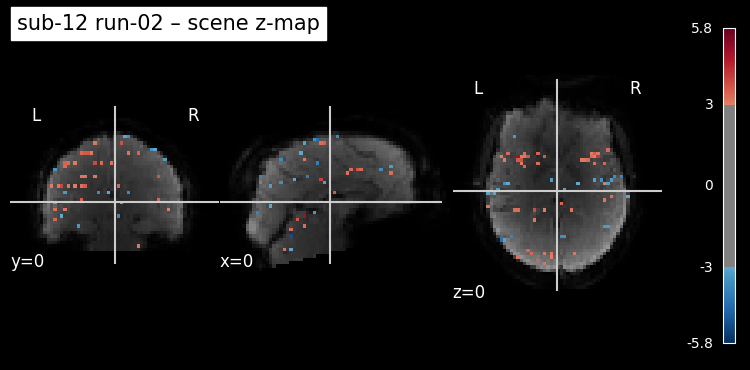

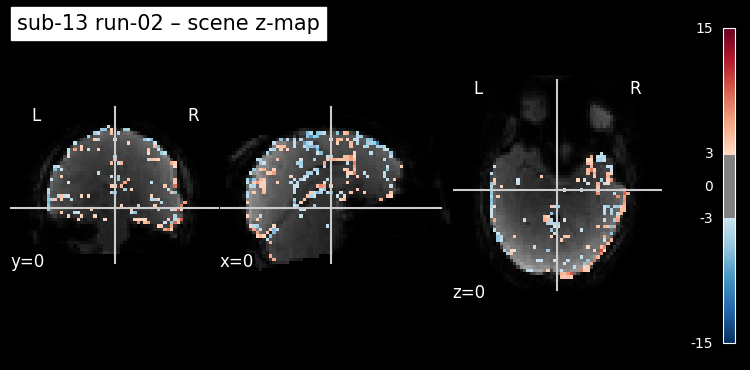

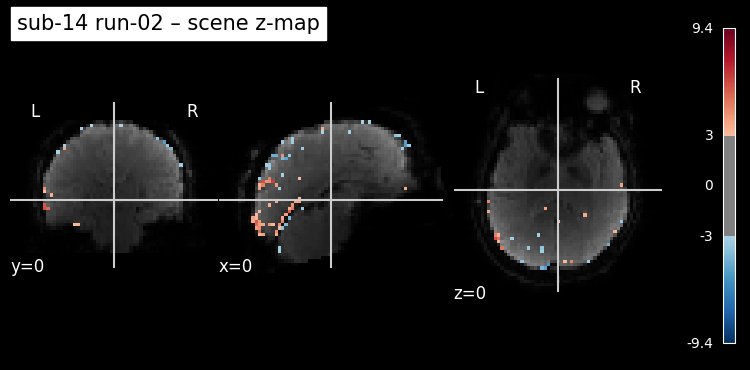

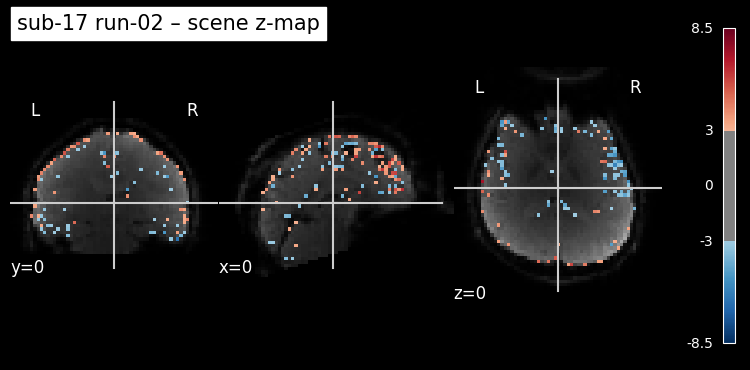

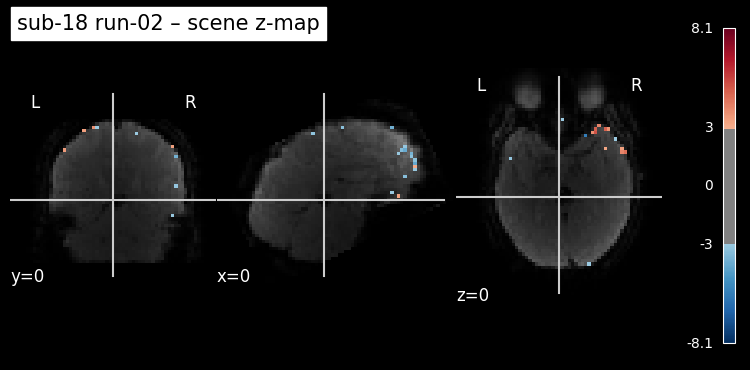

In [37]:
# Cell 7 – quick visualization of scene z-map for all 5 subjects

from IPython.display import display

subs_to_plot = ["sub-12", "sub-13", "sub-14", "sub-17", "sub-18"]

for sub_plot in subs_to_plot:
    print(f"Plotting {sub_plot} ...")

    # Get this subject's paths (run-02)
    paths_plot = get_subject_paths(sub_plot, run=2)

    # Path to this subject's z-map
    z_map_path = DERIV_ROOT / "firstlevel" / f"{sub_plot}_run-02_scene_zmap.nii.gz"
    if not z_map_path.exists():
        print(f"  [WARN] z-map not found at {z_map_path}")
        continue

    # Load z-map and mean EPI
    z_map    = image.load_img(z_map_path)
    mean_epi = image.mean_img(paths_plot["bold"])

    # Create and display the figure
    disp = plotting.plot_stat_map(
        z_map,
        bg_img=mean_epi,
        title=f"{sub_plot} run-02 – scene z-map",
        threshold=3.0,
        display_mode="ortho",
        cut_coords=(0, 0, 0),
    )
    display(disp)

# make sure all figures are flushed
plotting.show()



sub-12 – checking z-map at: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-12_run-02_scene_zmap.nii.gz
sub-12 run-02 – z-map stats:
  mean z : 0.07129210299354553
  std z  : 0.8601302738569749
  min z  : -5.1786949025986075
  max z  : 5.825249597587408


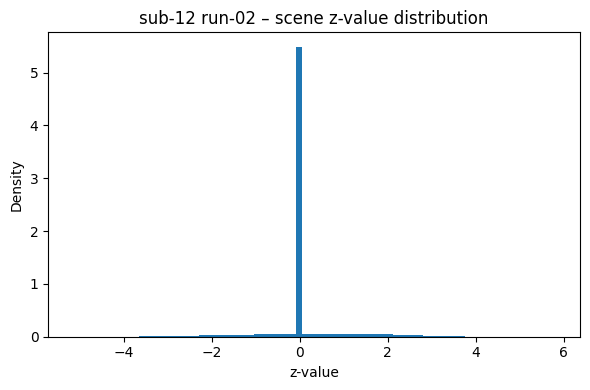


sub-13 – checking z-map at: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-13_run-02_scene_zmap.nii.gz
sub-13 run-02 – z-map stats:
  mean z : -0.018625872345015785
  std z  : 1.174708362082928
  min z  : -10.543896883378565
  max z  : 14.540004802501986


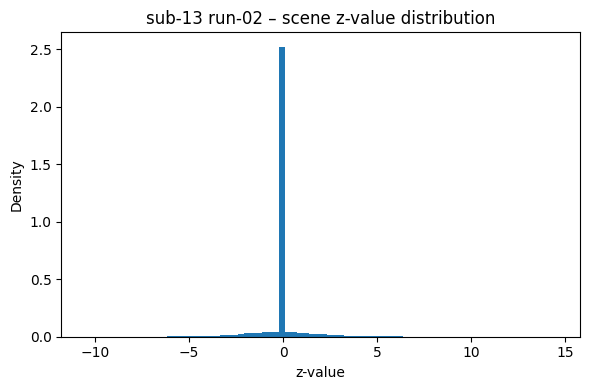


sub-14 – checking z-map at: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-14_run-02_scene_zmap.nii.gz
sub-14 run-02 – z-map stats:
  mean z : -0.020586940161132244
  std z  : 0.7926523020078273
  min z  : -9.417710794446167
  max z  : 8.711704705136205


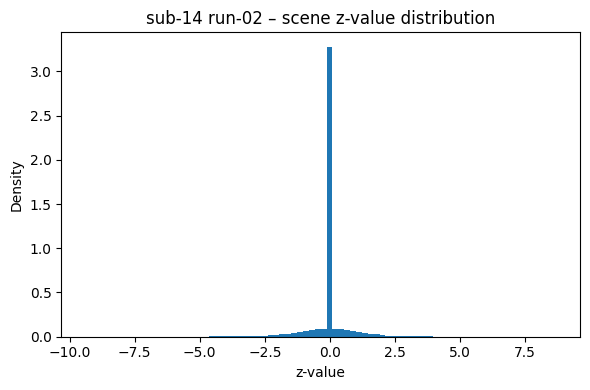


sub-17 – checking z-map at: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-17_run-02_scene_zmap.nii.gz
sub-17 run-02 – z-map stats:
  mean z : -0.025885995424347948
  std z  : 1.005577425668727
  min z  : -6.911607245229826
  max z  : 8.468926922653107


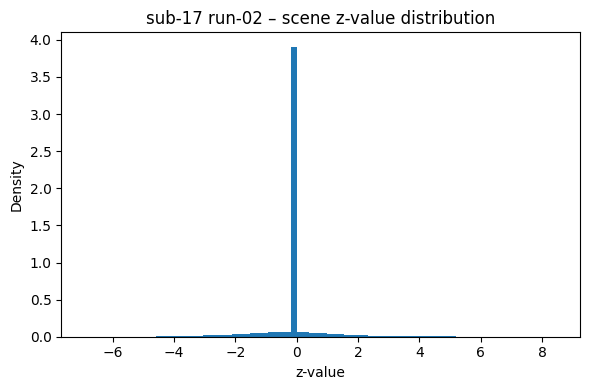


sub-18 – checking z-map at: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\firstlevel\sub-18_run-02_scene_zmap.nii.gz
sub-18 run-02 – z-map stats:
  mean z : -0.021328348644389292
  std z  : 0.7126660426475641
  min z  : -8.133805488986761
  max z  : 6.912164504993781


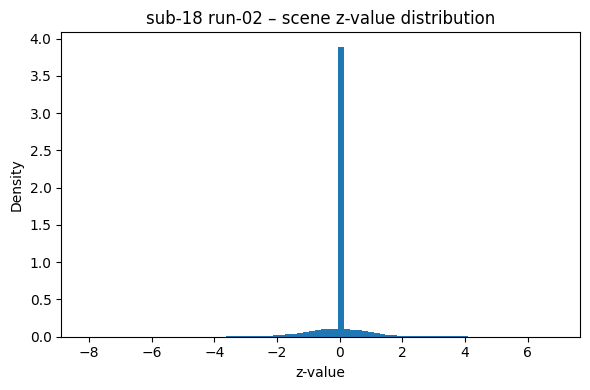

In [42]:
# Cell X – z-map stats and histograms for ALL movie subjects (run-02)

for sub_plot in SUBJECTS:   # SUBJECTS = ["sub-12", "sub-13", "sub-14", "sub-17", "sub-18"]
    z_map_path = FIRSTLEVEL_ROOT / f"{sub_plot}_run-02_scene_zmap.nii.gz"
    print(f"\n{sub_plot} – checking z-map at: {z_map_path}")
    
    if not z_map_path.exists():
        print(f"  [WARN] z-map missing for {sub_plot} – did Phase 4 GLM run for this subject?")
        continue

    # Load z-map and flatten
    z_map  = image.load_img(z_map_path)
    z_data = z_map.get_fdata()
    z_flat = z_data[np.isfinite(z_data)]   # drop NaNs / infs

    # Print summary stats
    print(f"{sub_plot} run-02 – z-map stats:")
    print("  mean z :", np.mean(z_flat))
    print("  std z  :", np.std(z_flat))
    print("  min z  :", np.min(z_flat))
    print("  max z  :", np.max(z_flat))

    # Histogram for this subject
    plt.figure(figsize=(6, 4))
    plt.hist(z_flat, bins=80, density=True)
    plt.xlabel("z-value")
    plt.ylabel("Density")
    plt.title(f"{sub_plot} run-02 – scene z-value distribution")
    plt.tight_layout()
    plt.show()


## Interpretation – First-level GLM (scene z-map)

For Phase 4 we ran a whole-brain GLM for each subject’s movie run-02, using
the `scene_hrf` regressor from Phase 3 to model our 5-minute scene.

### Example subject: sub-12 run-02

For sub-12, the scene contrast z-map shows:

- Clear **clusters of positive z-values** (warm colors) mainly in cortical
  areas, especially around expected grey-matter regions.
- Some **negative z-values** (cool colors), meaning a few voxels decrease
  their signal when the scene regressor is high.
- Background and outside-brain voxels are largely zero, as expected after
  masking.

The z-value summary for sub-12 is:

- **mean z ≈ 0.07** → overall the map is centered very close to zero,
  which is what we expect for a well-behaved contrast.
- **std z ≈ 0.86** → most voxels have small z-values (around −2 to +2),
  consistent with noise or weak effects.
- **min z ≈ −5.18**, **max z ≈ +5.83** → there is a small set of voxels
  with relatively strong positive or negative scene-related responses.

The histogram of z-values confirms this:

- The distribution is **peaked around 0**, with long but thin tails.
- Only a small proportion of voxels reach high |z| (e.g., > 3–4), which
  are the most likely candidates for true scene-related activation.

### What this tells us

- The GLM and design matrix are working as expected: most voxels behave
  like noise, but a subset shows **reliable activation linked to the
  5-minute scene**.
- The scene contrast z-map is therefore a reasonable first-level summary
  of how each subject’s brain responds to that movie segment.

In the next phase, we can:

- Combine these z-maps across subjects (group or ROI analysis), and/or
- Focus on specific regions (e.g., visual or higher-order areas) to see
  how strongly they track the scene over time.
